# Simulating LiteBIRD-like TODs with beamconv

This demo wants to show the functionalities of a simple simulation pipeline. The code, based on beamconv and DUCC, returns noisy TODs given an input map, LiteBIRD's scanning strategy, the focal plane specifics and the noise power spectrum. Your feedback is much appreciated!

### Preliminary steps
First, we import all the modules and libraries that we need. In particular:
- <b>beamconv</b> (<a href="https://github.com/AdriJD/beamconv">github.com/AdriJD/beamconv</a>) simulates the scanning of the CMB sky while incorporating realistic beams and scan strategies. This code uses (spin-)spherical harmonic representations of the (polarized) beam response and sky to generate simulated CMB detector signal timelines. Beams can be arbitrarily shaped. Pointing timelines can be read in or calculated on the fly. Optionally, the results can be binned on the sphere. The code makes use of qpoint (<a href="https://github.com/arahlin/qpoint">github.com/arahlin/qpoint</a>), a lightweight quaternion-based library for telescope pointing.
- <b>DUCC</b> (<a href="https://gitlab.mpcdf.mpg.de/mtr/ducc">gitlab.mpcdf.mpg.de/mtr/ducc</a>) is a collection of basic programming tools for numerical computation, including Fast Fourier Transforms, Spherical Harmonic Transforms, non-equispaced Fourier transforms, as well as some concrete applications like 4pi convolution on the sphere and gridding/degridding of radio interferometry data.

(The last lines are there for aestethic purposes only.)

In [11]:
# Importing modules and libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

from beamconv import ScanStrategy
import qpoint as qp

import ducc0

# Redefining color-maps
import copy
cmap_viridis = copy.copy(matplotlib.cm.get_cmap("viridis"))
cmap_magma = copy.copy(matplotlib.cm.get_cmap("magma"))

# Ignoring warnings (matplotlib)
import warnings
warnings.filterwarnings("ignore")

# For plots
import cycler

The Cls coefficients are read from an input file. Healpy evaluates the T, Q and U maps, which are then plotted.

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


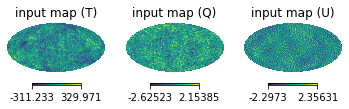

In [36]:
# Reading cls from .txt file
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',unpack=True)
ell, cls = cls[0], cls[1:]

# Calculating alm from cls and then producing map0
lmax=128
np.random.seed(25)
alm_clean = hp.synalm(cls, lmax=lmax, new=True, verbose=True)

map_clean = hp.alm2map(alm_clean, lmax)

# Plots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
plt.axes(ax1)
hp.mollview(map_clean[0],title='input map (T)', hold=True, cmap=cmap_viridis)
plt.axes(ax2)
hp.mollview(map_clean[1],title='input map (Q)', hold=True, cmap=cmap_viridis)
plt.axes(ax3)
hp.mollview(map_clean[2],title='input map (U)', hold=True, cmap=cmap_viridis)
plt.show()

The dipole should also be added:

In [13]:
#alm_clean[0,hp.sphtfunc.Alm.getidx(lmax,1,0)] = 5.124              # Adding the static dipole (a_10)
#alm_clean[0,hp.sphtfunc.Alm.getidx(lmax,1,1)] = (0.3384 - 3.215j)  # Adding the static dipole (a_11)

Foreground emission should also be added. I did that through <b>PySM 3</b>. It generates full-sky simulations of Galactic foregrounds in intensity and polarization relevant for CMB experiments. The components simulated are: thermal dust, synchrotron, AME, free-free, and CMB at a given HEALPix <code>nside</code>, with an option to integrate over a bandpass and to smooth with a given beam.

<b>TO DOs:</b>
- <p style="color:crimson">I had to redefine a function, since it complained that <code>verbose</code> was an unwanted argument of <code>alm2map</code>. Why is that?</p>
- The generation of a clean CMB map can be skipped including <code>c1</code> in the <code>preset_strings</code> list. Should I do so?

In [7]:
import pysm3
import pysm3.units as u

def apply_smoothing_and_coord_transform(
    input_map, fwhm=None, rot=None, lmax=None, map_dist=None
):
    """Apply smoothing and coordinate rotation to an input map

    it applies the `healpy.smoothing` Gaussian smoothing kernel if `map_dist`
    is None, otherwise applies distributed smoothing with `libsharp`.
    In the distributed case, no rotation is supported.

    Parameters
    ----------
    input_map : ndarray
        Input map, of shape `(3, npix)`
        This is assumed to have no beam at this point, as the
        simulated small scale tempatle on which the simulations are based
        have no beam.
    fwhm : astropy.units.Quantity
        Full width at half-maximum, defining the
        Gaussian kernels to be applied.
    rot: hp.Rotator
        Apply a coordinate rotation give a healpy `Rotator`, e.g. if the
        inputs are in Galactic, `hp.Rotator(coord=("G", "C"))` rotates
        to Equatorial

    Returns
    -------
    smoothed_map : np.ndarray
        Array containing the smoothed sky
    """

    if map_dist is None:
        nside = hp.get_nside(input_map)
        alm = hp.map2alm(
            input_map,
            lmax=lmax,
            use_pixel_weights=True if nside > 16 else False
        )
        if fwhm is not None:
            hp.smoothalm(
                alm, fwhm=fwhm.to_value(u.rad), inplace=True, pol=True
            )
        if rot is not None:
            rot.rotate_alm(alm, inplace=True)
        smoothed_map = hp.alm2map(alm, nside=nside, pixwin=False)

    else:
        assert (rot is None) or (
            rot.coordin == rot.coordout
        ), "No rotation supported in distributed smoothing"
        smoothed_map = mpi.mpi_smoothing(input_map, fwhm, map_dist)

    if hasattr(input_map, "unit"):
        smoothed_map <<= input_map.unit
    return smoothed_map

In [26]:
sky = pysm3.Sky(nside=256, preset_strings=["a1", "d1", "f1", "s1"], output_unit="uK_CMB")
nu = 220
map = sky.get_emission(nu * u.GHz)
map_equ = apply_smoothing_and_coord_transform(map, rot=hp.Rotator(coord="GC"))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [33]:
alm_equ = hp.map2alm(map_equ, lmax=lmax)
alm_FG = alm_clean + alm_equ

map_FG = hp.alm2map(alm_FG, lmax)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


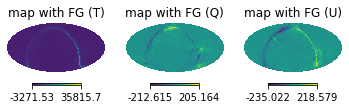

In [55]:
# Plots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
plt.axes(ax1)
hp.mollview(map_FG[0],title='map with FG (T)', hold=True, cmap=cmap_viridis)
plt.axes(ax2)
hp.mollview(map_FG[1],title='map with FG (Q)', hold=True, cmap=cmap_viridis)
plt.axes(ax3)
hp.mollview(map_FG[2],title='map with FG (U)', hold=True, cmap=cmap_viridis)
plt.show()

map0 = map_FG

Together with the <b>input maps</b>, we need to specify the <b>scanning strategy</b> and the <b>focal plane specifics</b>. Provided with that, beamconv is able to produce the TODs. 

### Scanning strategy
Here I define two <code>ScanStrategy</code> objects: one with and one without HWP.

In [39]:
# Setting up the scanning strategy parameters
ctime0 = 1510000000            # Initial time
mlen = 1 * 24 * 60 * 60        # Mission length in seconds (one day!)

# Definition of the scanning strategy making use of LiteBIRD's specifics (without HWP)
ss = ScanStrategy(duration=mlen,
        external_pointing=True,
        theta_antisun=45.,      # [deg]
        theta_boresight = 50.,  # [deg]
        freq_antisun = 192.348, # [min]
        freq_boresight = 0.314, # [rad/min]
        sample_rate = 19.1,     # [Hz]
        jitter_amp=0.0,
        ctime0=ctime0)

# Definition of the scanning strategy making use of LiteBIRD's specifics (with HWP)
ss_hwp = ScanStrategy(duration=mlen,
        external_pointing=True,
        theta_antisun=45.,      # [deg]
        theta_boresight = 50.,  # [deg]
        freq_antisun = 192.348, # [min]
        freq_boresight = 0.314, # [rad/min]
        sample_rate = 19.1,     # [Hz]
        jitter_amp=0.0,
        ctime0=ctime0)

In order to generate a LiteBIRD-like scanning strategy, some functionalities of <b>pyScan</b> (<a href="https://github.com/tmatsumu/LB_SYSPL_updated">github.com/tmatsumu/LB_SYSPL_updated</a>) have been implemented in beamconv. In particular
- The <code>litebird_scan</code> function returns a quaternion that describes the boresight orientation (\theta, \phi and \psi angles) at any time sample;
- <code>litebird_ctime</code>, instead, produces unix time (<code>ctime</code>) for a given chunk.

In [40]:
# Further options (without HWP)
scan_opts = dict(
        q_bore_func=ss.litebird_scan,
        ctime_func=ss.litebird_ctime,
        use_litebird_scan=True,
        q_bore_kwargs=dict(),
        ctime_kwargs=dict(),
        max_spin=2,
        nside_spin=128,
        preview_pointing=False,
        verbose=True,
        save_tod=True)

# Further options (with HWP)
scan_opts_hwp = dict(
        q_bore_func=ss_hwp.litebird_scan,
        ctime_func=ss_hwp.litebird_ctime,
        use_litebird_scan=True,
        q_bore_kwargs=dict(),
        ctime_kwargs=dict(),
        max_spin=2,
        nside_spin=128,
        preview_pointing=False,
        verbose=True,
        save_tod=True)

### Focal plane and beam specifics
So far the two <code>ScanStrategy</code> objects (with and without HWP) are exactly identical. We can specify the HWP features when defining the beam and creating the focal plane. In particular, the Mueller matrix can be set up in in beam options, while the HWP frequency can be specified with <code>set_hwp_mode</code>. Here I'm using 4 detectors, with polarization angles 0, 90, 45 and 135 deg.

In [41]:
# Create a grid of Gaussian beams
ndet = 4
azs = np.zeros((ndet,2))
els = np.zeros((ndet,2))
polangs = np.array([[0,0],[90,90],[45,45],[135,135]])
deads = np.array ([[1,0],[1,0],[1,0],[1,0]])

# Setting up the beam options
beam_opts = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=40)          # Gaussian co-pol beam, so only specify FWHM (arcmin)

# Setting up the beam options
beam_opts_hwp = dict(lmax=lmax,
                 btype='Gaussian',
                 fwhm=40,          # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 hwp_mueller=np.diag([1, 1, -1, -1]))

# Defining HWP frequency
ss_hwp.set_hwp_mod(mode='continuous', freq=88/60)

# Creating the focal planes (with and without HWP)
ss.input_focal_plane(azs, els, polangs, deads, combine=True, scatter=False, **beam_opts)
ss_hwp.input_focal_plane(azs, els, polangs, deads, combine=True, scatter=False, **beam_opts_hwp)

Last thing to set up is the partition of the mission in chunks.

In [42]:
# Calculate TODs in 10 chunks
nchunk = 10
nsamp_chunk = int(ss.mlen * ss.fsamp / nchunk)
nsamp = int(ss.mlen * ss.fsamp)

chunks = ss.partition_mission(nsamp_chunk)
chunks_hwp = ss_hwp.partition_mission(nsamp_chunk)

### Coverage maps
As a countercheck, let us produce the coverage maps.

In [44]:
%%capture

# Producing the coverage map
ss.allocate_maps(nside=128)
ss.scan_instrument_mpi(alm_FG, **scan_opts)
maps, cond, proj = ss.solve_for_map(return_proj = True)

ss_hwp.allocate_maps(nside=128)
ss_hwp.scan_instrument_mpi(alm_FG, **scan_opts_hwp)
maps_hwp, cond, proj_hwp = ss_hwp.solve_for_map(return_proj = True)

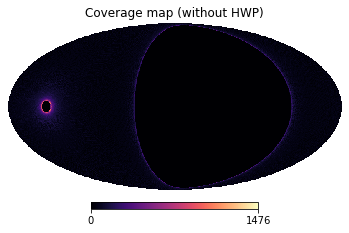

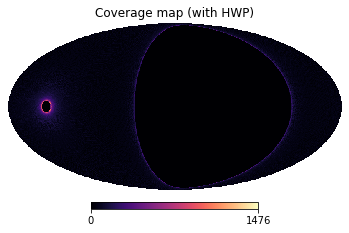

In [45]:
hp.mollview(proj[0],title='Coverage map (without HWP)', hold=True, cmap=cmap_magma)
plt.show()

hp.mollview(proj_hwp[0],title='Coverage map (with HWP)', hold=True, cmap=cmap_magma)
plt.show()

#hp.mollview(proj_hwp[0]-proj[0],title='Difference', hold=True, cmap=cmap_magma)
#plt.show()

### Injecting noise
By making use of DUCC we can produce a noise realization, given its power spectrum in frequency.

In [46]:
# Parameters for generating noise with ducc0 P(f)=sigma^2[(f^2+f_knee^2)/(f^2+f_min^2)]^(slope/2)
sigma = 10
f_min = 1e-4
f_knee = 1e-1
f_samp = 19.1
slope = -1.7

The clean TODs are produced by beamconv for each chunk, for both missions (with and without HWP). The same noise is added to the two missions, obtaining two sets of noisy TODs.

In [47]:
# Setting up and fillind TODs (clean, noisy and noise-only) 
clean_TOD = np.empty((ndet,nsamp))
noisy_TOD = np.empty((ndet,nsamp))
noise_TOD = np.empty((ndet,nsamp))

# Setting up and fillind TODs (clean, noisy and noise-only) 
clean_TOD_hwp = np.empty((ndet,nsamp))
noisy_TOD_hwp = np.empty((ndet,nsamp))
noise_TOD_hwp = np.empty((ndet,nsamp))

for det in np.arange(ndet):
    gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, f_samp, slope)
    for chunk in np.arange(nchunk):
        inp = np.random.normal(0.,1.,(nsamp_chunk,))
        noise = gen.filterGaussian(inp)
        #
        clean_data = ss.data(chunks[chunk],ss.beams[det][0],data_type='tod')
        noisy_data = clean_data + noise
        clean_TOD[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = clean_data
        noisy_TOD[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noisy_data
        noise_TOD[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noise
        #
        clean_data = ss_hwp.data(chunks_hwp[chunk],ss_hwp.beams[det][0],data_type='tod')
        noisy_data = clean_data + noise
        clean_TOD_hwp[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = clean_data
        noisy_TOD_hwp[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noisy_data
        noise_TOD_hwp[det,chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = noise

As a countercheck, we can plot the noise power spectrum for a given detector.

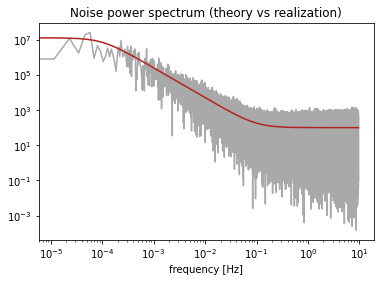

In [48]:
# Evaluating  and plotting the power spectrum
ps = np.abs(np.fft.fft(noise_TOD[0,:]))**2 / nsamp
time_step = 1. / f_samp
freqs = np.fft.fftfreq(noise_TOD[0,:].size, time_step)
ps_theory = sigma**2 * ((freqs**2+f_knee**2)/(freqs**2+f_min**2))**(-slope/2)

plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'darkgray')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'firebrick')
plt.title('Noise power spectrum (theory vs realization)')
plt.xlabel('frequency [Hz]')
plt.show()

Averaging 300 realizations of the noise, the power spectrum recovers the theoretical one.

In [12]:
ps = np.zeros(nsamp)
nps = int(300)

gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, f_samp, slope)

for i in np.arange(nps):
    noise = np.zeros(nsamp)
    for chunk in np.arange(nchunk):
        inp = np.random.normal(0.,1.,(nsamp_chunk,))
        #
        noise[chunk*nsamp_chunk:(chunk+1)*nsamp_chunk] = gen.filterGaussian(inp)
    ps += np.abs(np.fft.fft(noise))**2 / nsamp

ps = ps/nps

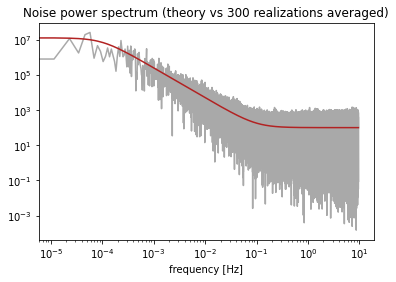

In [49]:
# Plotting the power spectrum
plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'darkgray')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'firebrick')
plt.title('Noise power spectrum (theory vs 300 realizations averaged)')
plt.xlabel('frequency [Hz]')
plt.show()

Also, we can see how the presence of the ideal HWP affects the TODs.

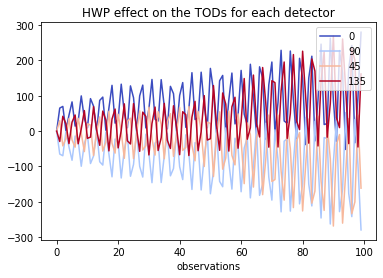

In [50]:
n = ndet
color = plt.cm.coolwarm(np.linspace(0,1,n))
matplotlib.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

plt.plot(clean_TOD_hwp[0][:100]-clean_TOD[0][:100],label='0')
plt.plot(clean_TOD_hwp[1][:100]-clean_TOD[1][:100],label='90')
plt.plot(clean_TOD_hwp[2][:100]-clean_TOD[2][:100],label='45')
plt.plot(clean_TOD_hwp[3][:100]-clean_TOD[3][:100],label='135')
plt.title('HWP effect on the TODs for each detector')
plt.legend(loc=1)
plt.xlabel('observations')
plt.show()

- The difference (TOD with HWP - TOD without HWP) is of the right order of magnitude, since the HWP only affects the Q and U contributions to the signal, whose absolute values is smaller than &sim;2;
- Detectors sensitive to orthogonal polarization directions have opposite (TOD with HWP - TOD without HWP) values.

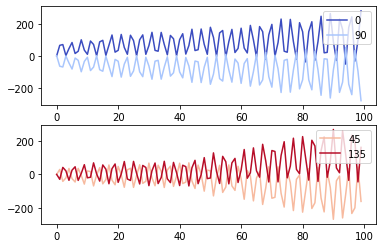

In [51]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

plt.axes(ax1)
ax1.plot(clean_TOD_hwp[0][:100]-clean_TOD[0][:100],label='0',color=plt.cm.coolwarm(0))
ax1.plot(clean_TOD_hwp[1][:100]-clean_TOD[1][:100],label='90',color=plt.cm.coolwarm(0.33))
ax1.legend(loc=1)

plt.axes(ax2)
ax2.plot(clean_TOD_hwp[2][:100]-clean_TOD[2][:100],label='45',color=plt.cm.coolwarm(0.66))
ax2.plot(clean_TOD_hwp[3][:100]-clean_TOD[3][:100],label='135',color=plt.cm.coolwarm(0.99))
ax2.legend(loc=1)

plt.show()

### Noisy TODs (with and without HWP)
 - The coverage maps look good;
 - The noise looks good;
 - The HWP behaves well.
 
Let's finally take a look at the noisy TODs for the whole mission.

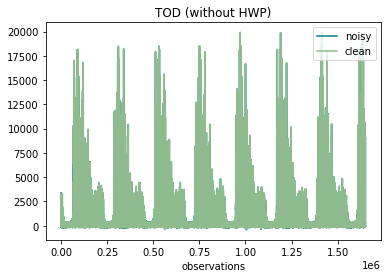

In [52]:
plt.plot(noisy_TOD[0,:],'teal',label='noisy')
plt.plot(clean_TOD[0,:],'darkseagreen',label='clean')
plt.legend(loc=1)
plt.title('TOD (without HWP)')
plt.xlabel('observations')
plt.show()

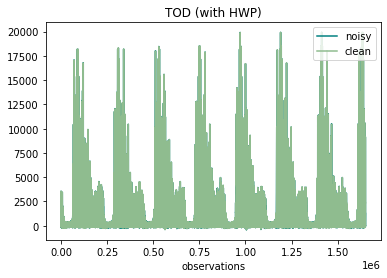

In [53]:
plt.plot(noisy_TOD_hwp[0,:],'teal',label='noisy')
plt.plot(clean_TOD_hwp[0,:],'darkseagreen',label='clean')
plt.legend(loc=1)
plt.title('TOD (with HWP)')
plt.xlabel('observations')
plt.show()

The clean TODs seem to be "periodic". This actually makes sense, since the "period" correspond to a precession period.

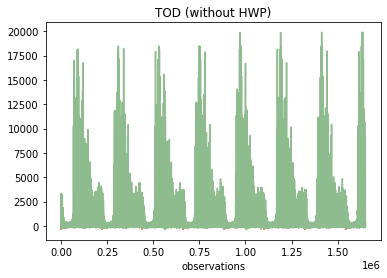

In [54]:
prec_idx = int(3.2058 * 60 * 60 * 19.1)

plt.plot(clean_TOD[0,:],'darkseagreen')
plt.vlines(0*prec_idx, -400, 400, colors='chocolate', linestyles='solid', label='')
plt.vlines(1*prec_idx, -400, 400, colors='chocolate', linestyles='solid', label='')
plt.vlines(2*prec_idx, -400, 400, colors='chocolate', linestyles='solid', label='')
plt.vlines(3*prec_idx, -400, 400, colors='chocolate', linestyles='solid', label='')
plt.vlines(4*prec_idx, -400, 400, colors='chocolate', linestyles='solid', label='')
plt.vlines(5*prec_idx, -400, 400, colors='chocolate', linestyles='solid', label='')
plt.vlines(6*prec_idx, -400, 400, colors='chocolate', linestyles='solid', label='')
plt.vlines(7*prec_idx, -400, 400, colors='chocolate', linestyles='solid', label='')
plt.title('TOD (without HWP)')
plt.xlabel('observations')
plt.show()

## Steps further
- Include HWP non-idealities
- More realistic focal plane
- More realistic beam shapes
- More realistic noise power spectrum
- Include the dipole (time-dependent in particular)
- Adapt this for production purposes (what does the collaboration need? which format?)